加载数据集

In [1]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
from mindspore import dtype as mstype

train_data_path = "flower_photos_train"
val_data_path = "flower_photos_test"


def create_dataset(data_path, batch_size=18, training=True):
    """定义数据集"""
    data_set = ds.ImageFolderDataset(
        data_path,
        num_parallel_workers=8,
        shuffle=True,
        class_indexing={
            "daisy": 0,
            "dandelion": 1,
            "roses": 2,
            "sunflowers": 3,
            "tulips": 4,
        },
    )
    # 对数据进行增强操作
    image_size = 224
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if training:
        trans = [
            CV.RandomCropDecodeResize(
                image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)
            ),
            CV.RandomHorizontalFlip(prob=0.5),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW(),
        ]
    else:
        trans = [CV.Decode(), CV.Resize(256), CV.CenterCrop(image_size), CV.HWC2CHW()]
    # 实现数据的map映射，批量处理和数据重复的操作
    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    data_set = data_set.batch(batch_size, drop_remainder=True)
    
    return data_set

dataset_train = create_dataset(train_data_path)
dataset_val = create_dataset(val_data_path)

[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:22.601.588 [mindspore/dataset/core/validator_helpers.py:806] 'RandomCropDecodeResize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCropDecodeResize' from mindspore.dataset.vision instead.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:22.602.703 [mindspore/dataset/core/validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:22.603.202 [mindspore/dataset/core/validator_helpers.py:806] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(14508:140598784

数据集可视化

Tensor of images (18, 3, 224, 224)
Labels [4 1 1 2 2 2 4 1 1 0 1 0 0 2 1 1 3 4]


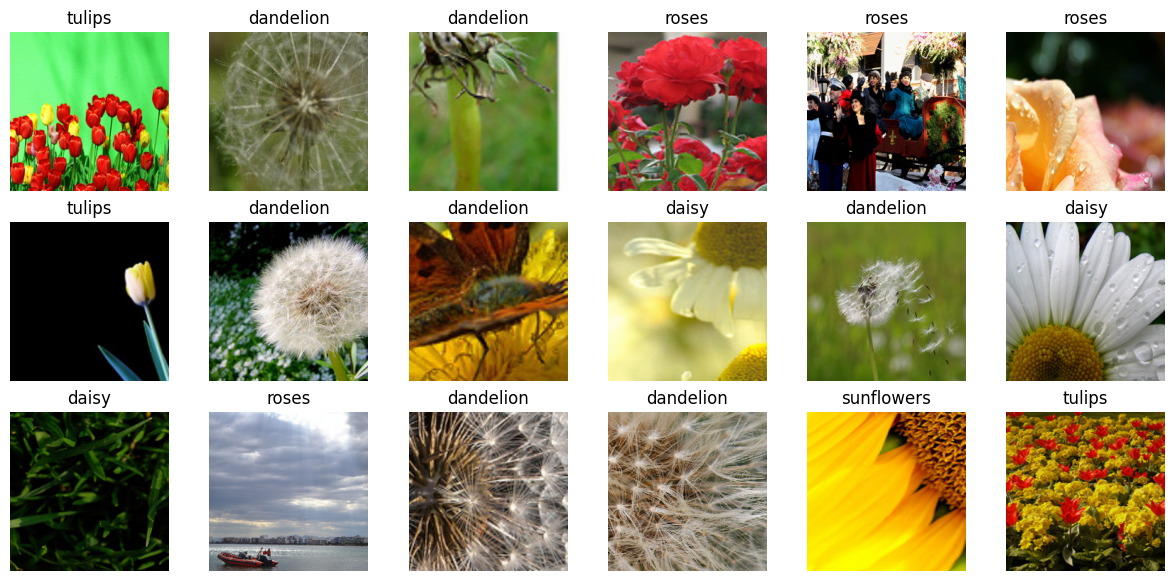

In [2]:
import matplotlib.pyplot as plt
import numpy as np

data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of images", images.shape)
print("Labels", labels)

# class_name 对应 label，并按文件夹字符串从小到大的顺序标记label
class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

创建 MobileNet V2 模型

In [3]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class GlobalAvgPooling(nn.Cell):
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()
        self.mean = ops.ReduceMean(keep_dims=False)

    def construct(self, x):
        x = self.mean(x, (2, 3))
        return x


class ConvBNReLU(nn.Cell):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        super(ConvBNReLU, self).__init__()
        padding = (kernel_size - 1) // 2
        in_channels = in_planes
        out_channels = out_planes
        if groups == 1:
            conv = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                pad_mode="pad",
                padding=padding,
            )
        else:
            out_channels = in_planes
            conv = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                pad_mode="pad",
                padding=padding,
                group=in_channels,
            )
        layers = [conv, nn.BatchNorm2d(out_channels), nn.ReLU6()]
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


class InvertedResidual(nn.Cell):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
            layers.extend(
                [
                    # dw
                    ConvBNReLU(
                        hidden_dim, hidden_dim, stride=stride, groups=hidden_dim
                    ),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, has_bias=False),
                    nn.BatchNorm2d(oup),
                ]
            )
        self.conv = nn.SequentialCell(layers)
        self.add = ops.Add()
        self.cast = ops.Cast()

    def construct(self, x):
        identity = x
        x = self.conv(x)
        if self.use_res_connect:
            return self.add(identity, x)
        return x


class MobileNet2Backbone(nn.Cell):
    def __init__(
        self,
        width_mult=1,
        inverted_residual_setting=None,
        round_nearest=8,
        input_channel=32,
        last_channel=1280,
    ):
        super(MobileNet2Backbone, self).__init__()
        block = InvertedResidual
        # setting of inverted residual blocks
        self.cfgs = inverted_residual_setting
        if inverted_residual_setting is None:
            self.cfgs = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]
        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.out_channels = _make_divisible(
            last_channel * max(1.0, width_mult), round_nearest
        )
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(
                    block(input_channel, output_channel, stride, expand_ratio=t)
                )
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))
        # make it nn.CellList
        self.features = nn.SequentialCell(features)
        self._initialize_weights()

    def construct(self, x):
        x = self.features(x)
        return x

    def _initialize_weights(self):
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.set_data(
                    ms.Tensor(
                        np.random.normal(
                            0, np.sqrt(2.0 / n), m.weight.data.shape
                        ).astype("float32")
                    )
                )
                if m.bias is not None:
                    m.bias.set_data(ms.numpy.zeros(m.bias.data.shape).astype("float32"))
            elif isinstance(m, nn.BatchNorm2d):
                m.gamma.set_data(
                    ms.Tensor(ms.numpy.ones(m.gamma.data.shape, dtype="float32"))
                )
                m.beta.set_data(ms.numpy.zeros(m.beta.data.shape, dtype="float32"))

    @property
    def get_features(self):
        return self.features


class MobileNetV2Head(nn.Cell):
    def __init__(
        self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"
    ):
        super(MobileNetV2Head, self).__init__()
        # mobile head
        head = (
            [GlobalAvgPooling()]
            if not has_dropout
            else [GlobalAvgPooling(), nn.Dropout(0.2)]
        )
        self.head = nn.SequentialCell(head)
        self.dense = nn.Dense(input_channel, num_classes, has_bias=True)
        self.need_activation = True
        if activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "Softmax":
            self.activation = nn.Softmax()
        else:
            self.need_activation = False
        self._initialize_weights()

    def construct(self, x):
        x = self.head(x)
        x = self.dense(x)
        if self.need_activation:
            x = self.activation(x)
        return x

    def _initialize_weights(self):
        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Dense):
                m.weight.set_data(
                    ms.Tensor(
                        np.random.normal(0, 0.01, m.weight.data.shape).astype("float32")
                    )
                )
                if m.bias is not None:
                    m.bias.set_data(ms.numpy.zeros(m.bias.data.shape).astype("float32"))


class MobileNetV2Combine(nn.Cell):
    def __init__(self, backbone, head):
        super(MobileNetV2Combine, self).__init__()
        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


def mobilenet_v2(num_classes):
    backbone_net = MobileNet2Backbone()
    head_net = MobileNetV2Head(backbone_net.out_channels, num_classes)
    return MobileNetV2Combine(backbone_net, head_net)

模型训练与评估

In [4]:
import mindspore
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import Tensor, save_checkpoint
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# 创建模型，其中目标分类数为5
network = mobilenet_v2(5)

# 加载预训练权重
param_dict = load_checkpoint(
    "./mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt"
)

# 根据修改的模型结构修改相应的权重数据
param_dict["dense.weight"] = mindspore.Parameter(
    Tensor(param_dict["dense.weight"][:5, :], mindspore.float32),
    name="dense.weight",
    requires_grad=True,
)
param_dict["dense.bias"] = mindspore.Parameter(
    Tensor(param_dict["dense.bias"][:5], mindspore.float32),
    name="dense.bias",
    requires_grad=True,
)
# 将修改后的权重参数加载到模型中
load_param_into_net(network, param_dict)

train_step_size = dataset_train.get_dataset_size()
epoch_size = 20
lr = nn.cosine_decay_lr(
    min_lr=0.0,
    max_lr=0.1,
    total_step=train_step_size * epoch_size,
    step_per_epoch=train_step_size,
    decay_epoch=200,
)
# 定义优化器
network_opt = nn.Momentum(
    params=network.trainable_params(), learning_rate=0.01, momentum=0.9
)

# 定义损失函数
network_loss = loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

# 损失值监控
loss_cb = LossMonitor(per_print_times=train_step_size)

# 模型保存参数，设置每隔多少步保存一次模型，最多保存几个模型
skpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=10)

# 模型保存，设置模型保存的名称，路径，以及保存参数
ckpoint_cb = ModelCheckpoint(prefix="mobilenetv2", directory="./ckpt", config=skpt_config)

print("============== Starting Training ==============")
# 模型训练模型，设置训练次数为5，训练集，回调函数
model.train(5, dataset_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)
# 使用测试集进行模型评估，输出测试集的准确率
metric = model.eval(dataset_val)
print(metric)

[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:25.190.607 [mindspore/train/serialization.py:714] For 'load_param_into_net', 252 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:25.191.359 [mindspore/train/serialization.py:716] backbone.features.0.features.0.weight is not loaded.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:25.191.807 [mindspore/train/serialization.py:716] backbone.features.0.features.1.moving_mean is not loaded.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:25.192.159 [mindspore/train/serialization.py:716] backbone.features.0.features.1.moving_variance is not loaded.
[WARNING] ME(14508:140598784952128,MainProcess):2023-07-13-10:33:25.192.497 [mindspore/train/serialization.py:716] backbone.features.0.features.1.gamma is 

============== Starting Training ==============


[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.005 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14508/506231113.py]
[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.037 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14508/506231113.py]
[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.306 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14508/506231113.py]
[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.317 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14508/506231113.py]
[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.327 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_14508/506231113.py]
[ERROR] CORE(14508,7fdfb4a20740,python):2023-07-13-10:33:26.676.462 [mindspore/core/u

RuntimeError: For 'Conv2D', 'C_in' of input 'x' shape divide by parameter 'group' must be equal to 'C_in' of input 'weight' shape: 16, but got 'C_in' of input 'x' shape: 32, and 'group': 1.

----------------------------------------------------
- The Traceback of Net Construct Code:
----------------------------------------------------
The function call stack (See file '/home/ma-user/work/HCIA-AI-Course/rank_0/om/analyze_fail.dat' for more details. Get instructions about `analyze_fail.dat` at https://www.mindspore.cn/search?inputValue=analyze_fail.dat):
# 0 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/wrap/cell_wrapper.py:380
        loss = self.network(*inputs)
               ^
# 1 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/wrap/cell_wrapper.py:117
        out = self._backbone(data)
              ^
# 2 In file /tmp/ipykernel_14508/506231113.py:217
# 3 In file /tmp/ipykernel_14508/506231113.py:141
# 4 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:278
        for cell in self.cell_list:
# 5 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:279
            input_data = cell(input_data)
                         ^
# 6 In file /tmp/ipykernel_14508/506231113.py:90
# 7 In file /tmp/ipykernel_14508/506231113.py:89
# 8 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:278
        for cell in self.cell_list:
# 9 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:279
            input_data = cell(input_data)
                         ^
# 10 In file /tmp/ipykernel_14508/506231113.py:57
# 11 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:278
        for cell in self.cell_list:
# 12 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/container.py:279
            input_data = cell(input_data)
                         ^
# 13 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/conv.py:309
        if self.has_bias:
# 14 In file /home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/mindspore/nn/layer/conv.py:308
        output = self.conv2d(x, self.weight)
                 ^

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore/core/ops/conv2d.cc:214 Conv2dInferShape


可视化模型预测

In [ ]:
import matplotlib.pyplot as plt
import mindspore as ms


def visualize_model(best_ckpt_path, val_ds):
    num_class = 5  # 对狼和狗图像进行二分类
    net = mobilenet_v2(num_class)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    # 预测图像类别
    output = model.predict(ms.Tensor(data["image"]))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = "blue" if pred[i] == labels[i] else "red"
        plt.title("predict:{}".format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis("off")

    plt.show()
visualize_model("ckpt/mobilenetv2-5_201.ckpt", dataset_val)